In [11]:
import os
import numpy as np 
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
def collect_file_paths(data_dir, max_images_per_class=1000):
    file_paths = []
    labels = []
    class_names = ['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia']
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        class_images = []
        for dirname, _, filenames in os.walk(class_dir):
            for filename in filenames:
                class_images.append(os.path.join(dirname, filename))
                if len(class_images) >= max_images_per_class:
                    break
            if len(class_images) >= max_images_per_class:
                break

        file_paths.extend(class_images)
        labels.extend([class_to_idx[class_name]] * len(class_images))
    return file_paths, labels

In [3]:
class MRIDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        img_array = np.array(img)
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:
            img = img.convert('L') 
        if self.transform:
            img = self.transform(img)
        return img, label
    
    @property
    def classes(self):
        return self.data.classes

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
data_dir = 'Data'
file_paths, labels = collect_file_paths(data_dir, max_images_per_class=2500)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)

train_dataset = MRIDataset(train_paths, train_labels, transform=transform)
test_dataset = MRIDataset(test_paths, test_labels, transform=transform)

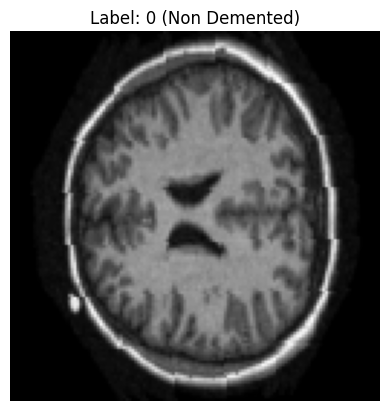

In [9]:
random_index = random.randint(0, len(train_dataset) - 1)
img, label = train_dataset[random_index]

if isinstance(img, torch.Tensor):
    img = img.numpy().squeeze()

class_names = ['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia']
label_name = class_names[label]

plt.imshow(img, cmap='gray')
plt.title(f'Label: {label} ({label_name})')
plt.axis('off')
plt.show()

In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

6390
1598


In [12]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)        
        x = x.view(x.size(0), -1) 
        x = self.fc(x)           
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
num_classes = 4
model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 1.9893
Epoch [2/10], Loss: 0.7716
Epoch [3/10], Loss: 0.6389
Epoch [4/10], Loss: 0.5896
Epoch [5/10], Loss: 0.5006
Epoch [6/10], Loss: 0.4737
Epoch [7/10], Loss: 0.4383
Epoch [8/10], Loss: 0.4025
Epoch [9/10], Loss: 0.3887
Epoch [10/10], Loss: 0.3605


In [15]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[
    'Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia'
])

print('confusion_matrix:')
print(cm)
print('\nClassification Report:') 
print(report)

confusion_matrix:
[[424  48   2  51]
 [  5 470   0  13]
 [  0   0  91   0]
 [ 80  71   0 343]]

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.83      0.81      0.82       525
     Mild Dementia       0.80      0.96      0.87       488
 Moderate Dementia       0.98      1.00      0.99        91
Very Mild Dementia       0.84      0.69      0.76       494

          accuracy                           0.83      1598
         macro avg       0.86      0.87      0.86      1598
      weighted avg       0.83      0.83      0.83      1598

